In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

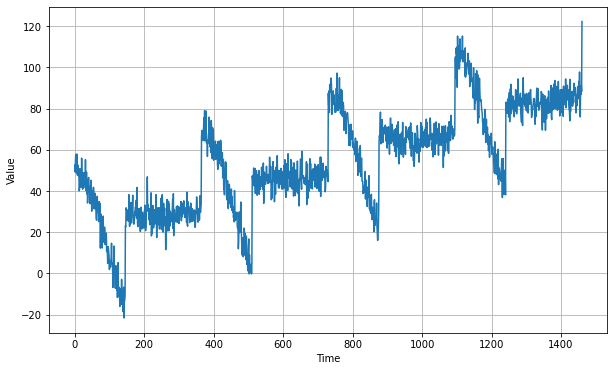

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [28]:
test = np.arange(10).reshape(2, 5)
print(test)
print(test.shape)

[[0 1 2 3 4]
 [5 6 7 8 9]]
(2, 5)


In [29]:
# add an outer batch axis
print(tf.expand_dims(test, axis=0).numpy())

# axis = 1 adds the second outer dimension
print(tf.expand_dims(test, axis=1).numpy())

# -1 counts from the end so adds inner most dimention
print(tf.expand_dims(test, axis=-1).numpy())

[[[0 1 2 3 4]
  [5 6 7 8 9]]]
[[[0 1 2 3 4]]

 [[5 6 7 8 9]]]
[[[0]
  [1]
  [2]
  [3]
  [4]]

 [[5]
  [6]
  [7]
  [8]
  [9]]]


In [ ]:
# learning rate schedule

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(20902490)
np.random.seed(20902490)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = tf.keras.models.Sequential([
    # add dim to each input so we could have dimention 1
    # input_shape = [[implicate batch_size], time_step: None, dim: 1]
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(100, return_sequences=True),
    tf.keras.layers.SimpleRNN(100),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 200.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 5s 259ms/step - loss: 203.0670 - mae: 203.5670 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 149.9161 - mae: 150.4156 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 71.7340 - mae: 72.2340 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 25.5745 - mae: 26.0708 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 28.5529 - mae: 29.0506 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 26ms/step - loss: 20.8016 - mae: 21.2933 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 18.2484 - mae: 18.7395 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 24ms/step - loss: 16.8709 - mae: 17.3616 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 23ms/step - loss: 15.7409 - mae: 16.2309 - lr

8/8 [==============================] - 0s 24ms/step - loss: 784.6852 - mae: 785.1852 - lr: 3.9811e-04
Epoch 74/100
8/8 [==============================] - 0s 23ms/step - loss: 876.6344 - mae: 877.1344 - lr: 4.4668e-04
Epoch 75/100
8/8 [==============================] - 0s 23ms/step - loss: 947.6606 - mae: 948.1606 - lr: 5.0119e-04
Epoch 76/100
8/8 [==============================] - 0s 23ms/step - loss: 1150.8860 - mae: 1151.3860 - lr: 5.6234e-04
Epoch 77/100
8/8 [==============================] - 0s 23ms/step - loss: 1249.1532 - mae: 1249.6532 - lr: 6.3096e-04
Epoch 78/100
8/8 [==============================] - 0s 26ms/step - loss: 1398.3375 - mae: 1398.8375 - lr: 7.0795e-04
Epoch 79/100
8/8 [==============================] - 0s 28ms/step - loss: 1710.9922 - mae: 1711.4922 - lr: 7.9433e-04
Epoch 80/100
8/8 [==============================] - 0s 24ms/step - loss: 1768.2250 - mae: 1768.7250 - lr: 8.9125e-04
Epoch 81/100
8/8 [==============================] - 0s 25ms/step - loss: 2090.2078 

(1e-07, 0.0001, 0.0, 30.0)

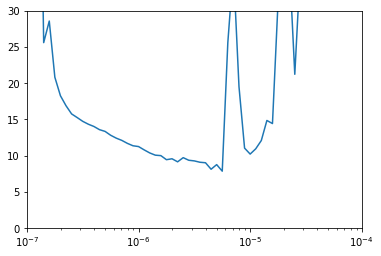

In [38]:
# use a base 10 scale on x but not on axis label
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-4, 0, 30])

In [ ]:
# early stopping

In [45]:
tf.keras.backend.clear_session()
tf.random.set_seed(20902490)
np.random.seed(20902490)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = tf.keras.models.Sequential([
    # add dim to each input so we could have dimention 1
    # input_shape = [[implicate batch_size], time_step: None, dim: 1]
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(100, return_sequences=True),
    tf.keras.layers.SimpleRNN(100),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 200.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=3e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=50)
# save the Keras model or model weights at some frequency: Model are saved at the end of every epoch, if it's the best seen
# so far
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("rnn_checkpoint", save_best_only=True)

model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping_callback, model_checkpoint])

Epoch 1/500
      7/Unknown - 2s 22ms/step - loss: 40.1951 - mae: 40.6923

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 10s 1s/step - loss: 38.6450 - mae: 39.1418 - val_loss: 30.5197 - val_mae: 31.0197
Epoch 2/500
7/8 [=========================>....] - ETA: 0s - loss: 19.0657 - mae: 19.5575

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 7s 974ms/step - loss: 19.3983 - mae: 19.8902 - val_loss: 7.6900 - val_mae: 8.1750
Epoch 3/500
8/8 [==============================] - 0s 32ms/step - loss: 13.8292 - mae: 14.3169 - val_loss: 25.7827 - val_mae: 26.2827
Epoch 4/500
8/8 [==============================] - 0s 33ms/step - loss: 11.3669 - mae: 11.8554 - val_loss: 10.6139 - val_mae: 11.1075
Epoch 5/500
8/8 [==============================] - 0s 32ms/step - loss: 10.2638 - mae: 10.7478 - val_loss: 12.8849 - val_mae: 13.3788
Epoch 6/500
8/8 [==============================] - 0s 36ms/step - loss: 9.0815 - mae: 9.5672 - val_loss: 13.2761 - val_mae: 13.7697
Epoch 7/500
8/8 [==============================] - 0s 33ms/step - loss: 9.7022 - mae: 10.1874 - val_loss: 13.5563 - val_mae: 14.0542
Epoch 8/500
7/8 [=========================>....] - ETA: 0s - loss: 10.7475 - mae: 11.2382

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 805ms/step - loss: 10.4168 - mae: 10.9072 - val_loss: 6.4789 - val_mae: 6.9650
Epoch 9/500
7/8 [=========================>....] - ETA: 0s - loss: 8.8100 - mae: 9.2982

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 8s 1s/step - loss: 8.7603 - mae: 9.2475 - val_loss: 6.0825 - val_mae: 6.5631
Epoch 10/500
8/8 [==============================] - 0s 32ms/step - loss: 9.4146 - mae: 9.9012 - val_loss: 7.5172 - val_mae: 8.0047
Epoch 11/500
8/8 [==============================] - 0s 35ms/step - loss: 9.8344 - mae: 10.3226 - val_loss: 6.2945 - val_mae: 6.7769
Epoch 12/500
8/8 [==============================] - 0s 35ms/step - loss: 7.8958 - mae: 8.3796 - val_loss: 6.5668 - val_mae: 7.0496
Epoch 13/500
8/8 [==============================] - 0s 33ms/step - loss: 6.6530 - mae: 7.1318 - val_loss: 7.0845 - val_mae: 7.5665
Epoch 14/500
8/8 [==============================] - 0s 33ms/step - loss: 7.3498 - mae: 7.8365 - val_loss: 7.4014 - val_mae: 7.8894
Epoch 15/500
7/8 [=========================>....] - ETA: 0s - loss: 7.8417 - mae: 8.3276

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 5s 763ms/step - loss: 7.7053 - mae: 8.1899 - val_loss: 5.8359 - val_mae: 6.3194
Epoch 16/500
8/8 [==============================] - 0s 37ms/step - loss: 7.3305 - mae: 7.8156 - val_loss: 6.8172 - val_mae: 7.2993
Epoch 17/500
8/8 [==============================] - 0s 38ms/step - loss: 8.5594 - mae: 9.0477 - val_loss: 11.5553 - val_mae: 12.0494
Epoch 18/500
8/8 [==============================] - 0s 37ms/step - loss: 13.0909 - mae: 13.5852 - val_loss: 10.0121 - val_mae: 10.5043
Epoch 19/500
8/8 [==============================] - 0s 37ms/step - loss: 13.4196 - mae: 13.9126 - val_loss: 16.9256 - val_mae: 17.4246
Epoch 20/500
8/8 [==============================] - 0s 42ms/step - loss: 9.3860 - mae: 9.8759 - val_loss: 13.1610 - val_mae: 13.6567
Epoch 21/500
8/8 [==============================] - 0s 39ms/step - loss: 8.2017 - mae: 8.6870 - val_loss: 7.0222 - val_mae: 7.5052
Epoch 22/500
8/8 [==============================] - 0s 46ms/step - loss: 6.7992 - m

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 835ms/step - loss: 4.9190 - mae: 5.3943 - val_loss: 5.4599 - val_mae: 5.9380
Epoch 42/500
8/8 [==============================] - 0s 37ms/step - loss: 5.4689 - mae: 5.9451 - val_loss: 6.4937 - val_mae: 6.9761
Epoch 43/500
8/8 [==============================] - 0s 39ms/step - loss: 5.3531 - mae: 5.8299 - val_loss: 5.9634 - val_mae: 6.4449
Epoch 44/500
8/8 [==============================] - 0s 42ms/step - loss: 4.8577 - mae: 5.3343 - val_loss: 6.0737 - val_mae: 6.5536
Epoch 45/500
8/8 [==============================] - 0s 42ms/step - loss: 5.5899 - mae: 6.0707 - val_loss: 5.8383 - val_mae: 6.3211
Epoch 46/500
7/8 [=========================>....] - ETA: 0s - loss: 5.4960 - mae: 5.9783

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 5s 727ms/step - loss: 5.7579 - mae: 6.2414 - val_loss: 5.3719 - val_mae: 5.8517
Epoch 47/500
8/8 [==============================] - 0s 36ms/step - loss: 9.2367 - mae: 9.7254 - val_loss: 7.8340 - val_mae: 8.3263
Epoch 48/500
8/8 [==============================] - 0s 43ms/step - loss: 8.8601 - mae: 9.3534 - val_loss: 6.6733 - val_mae: 7.1657
Epoch 49/500
8/8 [==============================] - 0s 38ms/step - loss: 8.2072 - mae: 8.6961 - val_loss: 5.8932 - val_mae: 6.3748
Epoch 50/500
8/8 [==============================] - 0s 36ms/step - loss: 7.8028 - mae: 8.2932 - val_loss: 6.3757 - val_mae: 6.8585
Epoch 51/500
8/8 [==============================] - 0s 39ms/step - loss: 9.2070 - mae: 9.6978 - val_loss: 6.4150 - val_mae: 6.8948
Epoch 52/500
8/8 [==============================] - 0s 44ms/step - loss: 6.5989 - mae: 7.0817 - val_loss: 6.4654 - val_mae: 6.9499
Epoch 53/500
8/8 [==============================] - 0s 42ms/step - loss: 5.3452 - mae: 5.8243 -

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 832ms/step - loss: 5.3564 - mae: 5.8332 - val_loss: 5.3201 - val_mae: 5.7955
Epoch 65/500
8/8 [==============================] - 0s 37ms/step - loss: 4.8368 - mae: 5.3172 - val_loss: 6.9243 - val_mae: 7.4084
Epoch 66/500
7/8 [=========================>....] - ETA: 0s - loss: 4.8285 - mae: 5.3050

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 5s 724ms/step - loss: 4.8022 - mae: 5.2790 - val_loss: 5.3021 - val_mae: 5.7818
Epoch 67/500
8/8 [==============================] - 0s 38ms/step - loss: 5.2137 - mae: 5.6939 - val_loss: 7.9431 - val_mae: 8.4309
Epoch 68/500
8/8 [==============================] - 0s 38ms/step - loss: 5.3111 - mae: 5.7894 - val_loss: 5.3468 - val_mae: 5.8275
Epoch 69/500
8/8 [==============================] - 0s 39ms/step - loss: 4.4640 - mae: 4.9402 - val_loss: 5.4889 - val_mae: 5.9669
Epoch 70/500
6/8 [=====================>........] - ETA: 0s - loss: 5.0122 - mae: 5.4909

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 5s 749ms/step - loss: 4.9569 - mae: 5.4377 - val_loss: 5.2837 - val_mae: 5.7597
Epoch 71/500
8/8 [==============================] - 0s 42ms/step - loss: 5.1521 - mae: 5.6347 - val_loss: 6.3015 - val_mae: 6.7881
Epoch 72/500
7/8 [=========================>....] - ETA: 0s - loss: 5.2537 - mae: 5.7327

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 7s 914ms/step - loss: 5.2232 - mae: 5.7026 - val_loss: 5.2005 - val_mae: 5.6786
Epoch 73/500
8/8 [==============================] - 0s 33ms/step - loss: 4.8732 - mae: 5.3508 - val_loss: 6.5808 - val_mae: 7.0624
Epoch 74/500
8/8 [==============================] - 0s 32ms/step - loss: 4.5056 - mae: 4.9834 - val_loss: 7.6264 - val_mae: 8.1145
Epoch 75/500
8/8 [==============================] - 0s 33ms/step - loss: 5.0202 - mae: 5.5002 - val_loss: 5.9175 - val_mae: 6.4003
Epoch 76/500
7/8 [=========================>....] - ETA: 0s - loss: 4.5871 - mae: 5.0619

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 812ms/step - loss: 4.6307 - mae: 5.1059 - val_loss: 5.1798 - val_mae: 5.6614
Epoch 77/500
8/8 [==============================] - 0s 34ms/step - loss: 4.7881 - mae: 5.2606 - val_loss: 5.2121 - val_mae: 5.6915
Epoch 78/500
8/8 [==============================] - 0s 35ms/step - loss: 4.8132 - mae: 5.2837 - val_loss: 7.0323 - val_mae: 7.5197
Epoch 79/500
8/8 [==============================] - 0s 42ms/step - loss: 4.8337 - mae: 5.3127 - val_loss: 5.1947 - val_mae: 5.6731
Epoch 80/500
8/8 [==============================] - 0s 45ms/step - loss: 4.8320 - mae: 5.3061 - val_loss: 5.4939 - val_mae: 5.9757
Epoch 81/500
8/8 [==============================] - 0s 40ms/step - loss: 5.3973 - mae: 5.8754 - val_loss: 6.8555 - val_mae: 7.3424
Epoch 82/500
8/8 [==============================] - 0s 43ms/step - loss: 5.2771 - mae: 5.7564 - val_loss: 5.5066 - val_mae: 5.9868
Epoch 83/500
8/8 [==============================] - 0s 42ms/step - loss: 4.8874 - mae: 5.3659 -

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 906ms/step - loss: 4.7981 - mae: 5.2733 - val_loss: 5.1482 - val_mae: 5.6212
Epoch 111/500
8/8 [==============================] - 0s 49ms/step - loss: 4.3041 - mae: 4.7764 - val_loss: 5.5992 - val_mae: 6.0785
Epoch 112/500
8/8 [==============================] - 0s 43ms/step - loss: 4.6619 - mae: 5.1362 - val_loss: 5.6296 - val_mae: 6.1093
Epoch 113/500
8/8 [==============================] - 0s 41ms/step - loss: 4.5850 - mae: 5.0632 - val_loss: 6.2068 - val_mae: 6.6956
Epoch 114/500
8/8 [==============================] - 0s 40ms/step - loss: 5.2196 - mae: 5.6983 - val_loss: 5.1820 - val_mae: 5.6598
Epoch 115/500
8/8 [==============================] - 0s 42ms/step - loss: 5.0925 - mae: 5.5705 - val_loss: 8.5487 - val_mae: 9.0412
Epoch 116/500
8/8 [==============================] - 0s 41ms/step - loss: 5.2628 - mae: 5.7411 - val_loss: 6.7060 - val_mae: 7.1916
Epoch 117/500
8/8 [==============================] - 0s 40ms/step - loss: 7.7672 - mae: 8

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 904ms/step - loss: 5.0758 - mae: 5.5520 - val_loss: 5.1476 - val_mae: 5.6277
Epoch 127/500
8/8 [==============================] - 0s 44ms/step - loss: 4.9894 - mae: 5.4682 - val_loss: 7.3173 - val_mae: 7.8053
Epoch 128/500
8/8 [==============================] - 0s 42ms/step - loss: 4.6231 - mae: 5.0985 - val_loss: 7.3921 - val_mae: 7.8825
Epoch 129/500
8/8 [==============================] - 0s 41ms/step - loss: 5.9723 - mae: 6.4507 - val_loss: 5.2124 - val_mae: 5.6933
Epoch 130/500
8/8 [==============================] - 0s 43ms/step - loss: 5.1998 - mae: 5.6780 - val_loss: 7.6970 - val_mae: 8.1853
Epoch 131/500
8/8 [==============================] - 1s 52ms/step - loss: 4.7786 - mae: 5.2638 - val_loss: 5.7170 - val_mae: 6.1967
Epoch 132/500
8/8 [==============================] - 0s 47ms/step - loss: 4.8793 - mae: 5.3569 - val_loss: 5.1864 - val_mae: 5.6647
Epoch 133/500
8/8 [==============================] - 0s 37ms/step - loss: 5.0656 - mae: 5

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 778ms/step - loss: 4.4887 - mae: 4.9680 - val_loss: 5.1269 - val_mae: 5.6068
Epoch 170/500
8/8 [==============================] - 0s 41ms/step - loss: 4.3547 - mae: 4.8287 - val_loss: 5.1575 - val_mae: 5.6309
Epoch 171/500
8/8 [==============================] - 0s 39ms/step - loss: 4.5480 - mae: 5.0227 - val_loss: 5.4253 - val_mae: 5.9036
Epoch 172/500
8/8 [==============================] - 0s 42ms/step - loss: 4.3564 - mae: 4.8330 - val_loss: 6.8066 - val_mae: 7.2947
Epoch 173/500
8/8 [==============================] - 0s 41ms/step - loss: 4.3985 - mae: 4.8724 - val_loss: 5.7153 - val_mae: 6.1985
Epoch 174/500
7/8 [=========================>....] - ETA: 0s - loss: 4.8265 - mae: 5.3036

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 783ms/step - loss: 4.8463 - mae: 5.3237 - val_loss: 4.9933 - val_mae: 5.4733
Epoch 175/500
8/8 [==============================] - 0s 38ms/step - loss: 4.8122 - mae: 5.2896 - val_loss: 5.8227 - val_mae: 6.3105
Epoch 176/500
8/8 [==============================] - 0s 38ms/step - loss: 5.3755 - mae: 5.8555 - val_loss: 5.4386 - val_mae: 5.9224
Epoch 177/500
8/8 [==============================] - 0s 40ms/step - loss: 7.0206 - mae: 7.5094 - val_loss: 7.1778 - val_mae: 7.6680
Epoch 178/500
8/8 [==============================] - 0s 38ms/step - loss: 5.2839 - mae: 5.7646 - val_loss: 5.5845 - val_mae: 6.0644
Epoch 179/500
8/8 [==============================] - 0s 37ms/step - loss: 4.4672 - mae: 4.9430 - val_loss: 5.5654 - val_mae: 6.0529
Epoch 180/500
8/8 [==============================] - 0s 43ms/step - loss: 4.3297 - mae: 4.8043 - val_loss: 8.8244 - val_mae: 9.3157
Epoch 181/500
8/8 [==============================] - 1s 50ms/step - loss: 5.1514 - mae: 5

In [ ]:
sequence_to_vector_model = keras.models.load_model("rnn_checkpoint")

In [46]:
rnn_forecast = model_forecast(model, series[split_time - window_size: -1], window_size)

15/15 [==============================] - 0s 5ms/step


In [51]:
rnn_forecast = rnn_forecast[: ,0]

7.2522078

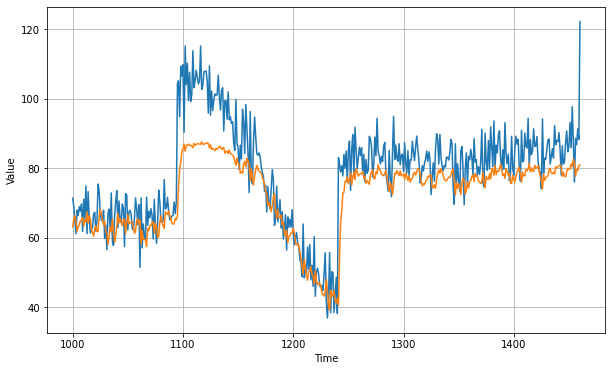

In [53]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
# sequence-to-sequence forecasting

In [62]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    # if expand_dim in keras model => then output will only have 1 dim => vector
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [67]:
for x, y in seq2seq_window_dataset(series, 30).take(1):
    print(x.shape)
    print(y.shape)

(32, 30, 1)
(32, 30, 1)


In [63]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]


In [72]:
tf.keras.backend.clear_session()
tf.random.set_seed(20902490)
np.random.seed(20902490)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = tf.keras.models.Sequential([
    # dim = 1
    tf.keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(100, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 200.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 26ms/step - loss: 147.7918 - mae: 148.2917 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 67.4836 - mae: 67.9825 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 40.5874 - mae: 41.0852 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 32.4302 - mae: 32.9266 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 28.2463 - mae: 28.7422 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 22ms/step - loss: 23.8737 - mae: 24.3655 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 26ms/step - loss: 22.0384 - mae: 22.5304 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 21.2297 - mae: 21.7204 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 23ms/step - loss: 20.5741 - mae: 21.0647 - lr: 2

8/8 [==============================] - 0s 23ms/step - loss: 785.1303 - mae: 785.6303 - lr: 3.9811e-04
Epoch 74/100
8/8 [==============================] - 0s 24ms/step - loss: 849.8712 - mae: 850.3712 - lr: 4.4668e-04
Epoch 75/100
8/8 [==============================] - 0s 23ms/step - loss: 823.6462 - mae: 824.1455 - lr: 5.0119e-04
Epoch 76/100
8/8 [==============================] - 0s 24ms/step - loss: 1915.8217 - mae: 1916.3217 - lr: 5.6234e-04
Epoch 77/100
8/8 [==============================] - 0s 23ms/step - loss: 922.4993 - mae: 922.9993 - lr: 6.3096e-04
Epoch 78/100
8/8 [==============================] - 0s 22ms/step - loss: 2784.5381 - mae: 2785.0381 - lr: 7.0795e-04
Epoch 79/100
8/8 [==============================] - 0s 23ms/step - loss: 1975.5247 - mae: 1976.0248 - lr: 7.9433e-04
Epoch 80/100
8/8 [==============================] - 0s 23ms/step - loss: 3459.9490 - mae: 3460.4492 - lr: 8.9125e-04
Epoch 81/100
8/8 [==============================] - 0s 25ms/step - loss: 3699.5957 - 

(1e-07, 0.0001, 0.0, 30.0)

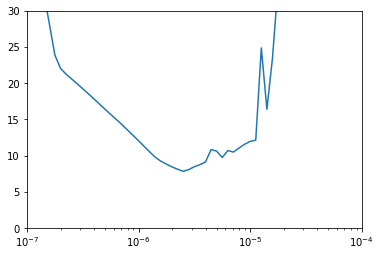

In [73]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-4, 0, 30])

In [74]:
tf.keras.backend.clear_session()
tf.random.set_seed(20902490)
np.random.seed(20902490)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = tf.keras.models.Sequential([
    # dim = 1
    tf.keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(100, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 200.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("rnn_checkpoint", save_best_only=True)

model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping_callback, model_checkpoint])

Epoch 1/500
      6/Unknown - 2s 25ms/step - loss: 77.7950 - mae: 78.2936

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 8s 871ms/step - loss: 70.3105 - mae: 70.8086 - val_loss: 49.9154 - val_mae: 50.4151
Epoch 2/500
7/8 [=========================>....] - ETA: 0s - loss: 39.6686 - mae: 40.1656

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 832ms/step - loss: 38.7716 - mae: 39.2681 - val_loss: 24.2156 - val_mae: 24.7123
Epoch 3/500
7/8 [=========================>....] - ETA: 0s - loss: 31.0827 - mae: 31.5781

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 854ms/step - loss: 30.6298 - mae: 31.1254 - val_loss: 21.3709 - val_mae: 21.8655
Epoch 4/500
7/8 [=========================>....] - ETA: 0s - loss: 23.0664 - mae: 23.5590

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 798ms/step - loss: 22.9141 - mae: 23.4063 - val_loss: 13.7115 - val_mae: 14.2022
Epoch 5/500
8/8 [==============================] - 0s 36ms/step - loss: 18.2024 - mae: 18.6919 - val_loss: 18.7525 - val_mae: 19.2476
Epoch 6/500
8/8 [==============================] - 0s 37ms/step - loss: 15.2299 - mae: 15.7172 - val_loss: 15.5054 - val_mae: 15.9988
Epoch 7/500
6/8 [=====================>........] - ETA: 0s - loss: 13.3021 - mae: 13.7866

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 846ms/step - loss: 13.1279 - mae: 13.6126 - val_loss: 11.9924 - val_mae: 12.4807
Epoch 8/500
8/8 [==============================] - ETA: 0s - loss: 11.4640 - mae: 11.9474

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 808ms/step - loss: 11.4640 - mae: 11.9474 - val_loss: 9.6937 - val_mae: 10.1771
Epoch 9/500
7/8 [=========================>....] - ETA: 0s - loss: 10.1532 - mae: 10.6365

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 791ms/step - loss: 10.1220 - mae: 10.6055 - val_loss: 9.2489 - val_mae: 9.7332
Epoch 10/500
7/8 [=========================>....] - ETA: 0s - loss: 8.9738 - mae: 9.4564

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 865ms/step - loss: 9.1013 - mae: 9.5840 - val_loss: 8.0641 - val_mae: 8.5491
Epoch 11/500
7/8 [=========================>....] - ETA: 0s - loss: 8.2178 - mae: 8.7002

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 5s 750ms/step - loss: 8.1860 - mae: 8.6684 - val_loss: 7.0886 - val_mae: 7.5736
Epoch 12/500
6/8 [=====================>........] - ETA: 0s - loss: 7.6927 - mae: 8.1751

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 842ms/step - loss: 7.6657 - mae: 8.1478 - val_loss: 6.6624 - val_mae: 7.1429
Epoch 13/500
8/8 [==============================] - 0s 43ms/step - loss: 7.3104 - mae: 7.7919 - val_loss: 7.0110 - val_mae: 7.4970
Epoch 14/500
8/8 [==============================] - 0s 42ms/step - loss: 7.0221 - mae: 7.5005 - val_loss: 6.8595 - val_mae: 7.3437
Epoch 15/500
7/8 [=========================>....] - ETA: 0s - loss: 6.7588 - mae: 7.2368

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 819ms/step - loss: 6.8108 - mae: 7.2889 - val_loss: 6.4073 - val_mae: 6.8878
Epoch 16/500
6/8 [=====================>........] - ETA: 0s - loss: 6.8259 - mae: 7.3039

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 898ms/step - loss: 6.6578 - mae: 7.1354 - val_loss: 6.0466 - val_mae: 6.5266
Epoch 17/500
8/8 [==============================] - 0s 45ms/step - loss: 6.5713 - mae: 7.0513 - val_loss: 6.5955 - val_mae: 7.0773
Epoch 18/500
8/8 [==============================] - 0s 40ms/step - loss: 6.4317 - mae: 6.9108 - val_loss: 6.1200 - val_mae: 6.6001
Epoch 19/500
8/8 [==============================] - 0s 44ms/step - loss: 6.3206 - mae: 6.7994 - val_loss: 6.0940 - val_mae: 6.5763
Epoch 20/500
6/8 [=====================>........] - ETA: 0s - loss: 6.3333 - mae: 6.8128

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 868ms/step - loss: 6.2691 - mae: 6.7485 - val_loss: 5.9922 - val_mae: 6.4735
Epoch 21/500
8/8 [==============================] - 0s 39ms/step - loss: 6.1497 - mae: 6.6289 - val_loss: 6.1449 - val_mae: 6.6272
Epoch 22/500
8/8 [==============================] - ETA: 0s - loss: 6.0945 - mae: 6.5728

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 5s 755ms/step - loss: 6.0945 - mae: 6.5728 - val_loss: 5.8308 - val_mae: 6.3098
Epoch 23/500
8/8 [==============================] - 0s 40ms/step - loss: 6.0366 - mae: 6.5155 - val_loss: 6.0732 - val_mae: 6.5537
Epoch 24/500
7/8 [=========================>....] - ETA: 0s - loss: 5.9834 - mae: 6.4615

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 827ms/step - loss: 5.9750 - mae: 6.4532 - val_loss: 5.8158 - val_mae: 6.2978
Epoch 25/500
7/8 [=========================>....] - ETA: 0s - loss: 5.8930 - mae: 6.3720

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 7s 942ms/step - loss: 5.8962 - mae: 6.3750 - val_loss: 5.6936 - val_mae: 6.1716
Epoch 26/500
8/8 [==============================] - 0s 41ms/step - loss: 5.8617 - mae: 6.3398 - val_loss: 6.0971 - val_mae: 6.5769
Epoch 27/500
8/8 [==============================] - 0s 42ms/step - loss: 5.7901 - mae: 6.2684 - val_loss: 5.7731 - val_mae: 6.2560
Epoch 28/500
8/8 [==============================] - 0s 41ms/step - loss: 5.7407 - mae: 6.2184 - val_loss: 5.7501 - val_mae: 6.2326
Epoch 29/500
7/8 [=========================>....] - ETA: 0s - loss: 5.7634 - mae: 6.2413

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 783ms/step - loss: 5.7218 - mae: 6.1996 - val_loss: 5.5553 - val_mae: 6.0333
Epoch 30/500
8/8 [==============================] - 0s 40ms/step - loss: 5.6813 - mae: 6.1589 - val_loss: 5.6996 - val_mae: 6.1820
Epoch 31/500
8/8 [==============================] - 0s 42ms/step - loss: 5.6417 - mae: 6.1197 - val_loss: 5.7495 - val_mae: 6.2284
Epoch 32/500
7/8 [=========================>....] - ETA: 0s - loss: 5.6027 - mae: 6.0804

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 8s 1s/step - loss: 5.6248 - mae: 6.1026 - val_loss: 5.4575 - val_mae: 5.9356
Epoch 33/500
8/8 [==============================] - 0s 38ms/step - loss: 5.6106 - mae: 6.0880 - val_loss: 6.0270 - val_mae: 6.5071
Epoch 34/500
7/8 [=========================>....] - ETA: 0s - loss: 5.6013 - mae: 6.0797

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 825ms/step - loss: 5.6060 - mae: 6.0842 - val_loss: 5.3739 - val_mae: 5.8553
Epoch 35/500
8/8 [==============================] - 0s 42ms/step - loss: 5.6013 - mae: 6.0795 - val_loss: 5.7578 - val_mae: 6.2353
Epoch 36/500
8/8 [==============================] - 0s 40ms/step - loss: 5.5185 - mae: 5.9954 - val_loss: 5.4377 - val_mae: 5.9180
Epoch 37/500
8/8 [==============================] - 0s 41ms/step - loss: 5.4844 - mae: 5.9619 - val_loss: 5.4674 - val_mae: 5.9500
Epoch 38/500
8/8 [==============================] - 0s 41ms/step - loss: 5.4522 - mae: 5.9285 - val_loss: 5.6587 - val_mae: 6.1358
Epoch 39/500
7/8 [=========================>....] - ETA: 0s - loss: 5.4537 - mae: 5.9301

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 7s 1s/step - loss: 5.4377 - mae: 5.9140 - val_loss: 5.3654 - val_mae: 5.8442
Epoch 40/500
8/8 [==============================] - 0s 44ms/step - loss: 5.4106 - mae: 5.8865 - val_loss: 5.5775 - val_mae: 6.0560
Epoch 41/500
8/8 [==============================] - 0s 43ms/step - loss: 5.3875 - mae: 5.8638 - val_loss: 5.6277 - val_mae: 6.1047
Epoch 42/500
7/8 [=========================>....] - ETA: 0s - loss: 5.2906 - mae: 5.7663

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 791ms/step - loss: 5.3660 - mae: 5.8417 - val_loss: 5.3499 - val_mae: 5.8289
Epoch 43/500
8/8 [==============================] - 0s 40ms/step - loss: 5.3439 - mae: 5.8196 - val_loss: 5.4787 - val_mae: 5.9598
Epoch 44/500
7/8 [=========================>....] - ETA: 0s - loss: 5.3468 - mae: 5.8232

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 843ms/step - loss: 5.3344 - mae: 5.8109 - val_loss: 5.3067 - val_mae: 5.7851
Epoch 45/500
8/8 [==============================] - 0s 42ms/step - loss: 5.3131 - mae: 5.7889 - val_loss: 5.4247 - val_mae: 5.9069
Epoch 46/500
8/8 [==============================] - 0s 41ms/step - loss: 5.2904 - mae: 5.7670 - val_loss: 5.3787 - val_mae: 5.8613
Epoch 47/500
8/8 [==============================] - 0s 41ms/step - loss: 5.2579 - mae: 5.7334 - val_loss: 5.4570 - val_mae: 5.9376
Epoch 48/500
7/8 [=========================>....] - ETA: 0s - loss: 5.2975 - mae: 5.7733

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 5s 747ms/step - loss: 5.2448 - mae: 5.7204 - val_loss: 5.2625 - val_mae: 5.7409
Epoch 49/500
8/8 [==============================] - 0s 41ms/step - loss: 5.2438 - mae: 5.7194 - val_loss: 5.5041 - val_mae: 5.9819
Epoch 50/500
7/8 [=========================>....] - ETA: 0s - loss: 5.2435 - mae: 5.7187

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 855ms/step - loss: 5.2259 - mae: 5.7009 - val_loss: 5.2098 - val_mae: 5.6897
Epoch 51/500
8/8 [==============================] - 0s 44ms/step - loss: 5.2460 - mae: 5.7223 - val_loss: 5.5927 - val_mae: 6.0693
Epoch 52/500
8/8 [==============================] - 0s 40ms/step - loss: 5.2206 - mae: 5.6959 - val_loss: 5.3519 - val_mae: 5.8349
Epoch 53/500
8/8 [==============================] - 0s 43ms/step - loss: 5.1720 - mae: 5.6470 - val_loss: 5.4706 - val_mae: 5.9485
Epoch 54/500
8/8 [==============================] - 0s 39ms/step - loss: 5.1587 - mae: 5.6340 - val_loss: 5.2899 - val_mae: 5.7708
Epoch 55/500
8/8 [==============================] - 0s 41ms/step - loss: 5.1438 - mae: 5.6188 - val_loss: 5.3235 - val_mae: 5.8061
Epoch 56/500
8/8 [==============================] - 0s 40ms/step - loss: 5.1371 - mae: 5.6115 - val_loss: 5.5210 - val_mae: 5.9974
Epoch 57/500
7/8 [=========================>....] - ETA: 0s - loss: 5.1766 - mae: 5.6530

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 863ms/step - loss: 5.1742 - mae: 5.6504 - val_loss: 5.1627 - val_mae: 5.6433
Epoch 58/500
8/8 [==============================] - 0s 44ms/step - loss: 5.1953 - mae: 5.6713 - val_loss: 5.8806 - val_mae: 6.3627
Epoch 59/500
8/8 [==============================] - 0s 41ms/step - loss: 5.1592 - mae: 5.6358 - val_loss: 5.2133 - val_mae: 5.6927
Epoch 60/500
8/8 [==============================] - 0s 39ms/step - loss: 5.1540 - mae: 5.6299 - val_loss: 5.5165 - val_mae: 5.9930
Epoch 61/500
8/8 [==============================] - 0s 40ms/step - loss: 5.0862 - mae: 5.5611 - val_loss: 5.1628 - val_mae: 5.6432
Epoch 62/500
8/8 [==============================] - 0s 44ms/step - loss: 5.1236 - mae: 5.5999 - val_loss: 5.4706 - val_mae: 5.9473
Epoch 63/500
6/8 [=====================>........] - ETA: 0s - loss: 5.0551 - mae: 5.5308

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 823ms/step - loss: 5.0864 - mae: 5.5622 - val_loss: 5.1291 - val_mae: 5.6091
Epoch 64/500
8/8 [==============================] - 0s 40ms/step - loss: 5.0612 - mae: 5.5361 - val_loss: 5.4467 - val_mae: 5.9237
Epoch 65/500
8/8 [==============================] - 0s 44ms/step - loss: 5.0271 - mae: 5.5018 - val_loss: 5.3943 - val_mae: 5.8735
Epoch 66/500
8/8 [==============================] - 0s 40ms/step - loss: 5.0606 - mae: 5.5355 - val_loss: 5.3068 - val_mae: 5.7888
Epoch 67/500
8/8 [==============================] - 0s 38ms/step - loss: 5.0260 - mae: 5.5013 - val_loss: 5.5042 - val_mae: 5.9805
Epoch 68/500
7/8 [=========================>....] - ETA: 0s - loss: 4.9958 - mae: 5.4697

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 808ms/step - loss: 5.0042 - mae: 5.4781 - val_loss: 5.0998 - val_mae: 5.5797
Epoch 69/500
8/8 [==============================] - 0s 40ms/step - loss: 5.0386 - mae: 5.5137 - val_loss: 5.3948 - val_mae: 5.8723
Epoch 70/500
8/8 [==============================] - 0s 41ms/step - loss: 4.9946 - mae: 5.4683 - val_loss: 5.1515 - val_mae: 5.6311
Epoch 71/500
8/8 [==============================] - 0s 42ms/step - loss: 4.9833 - mae: 5.4578 - val_loss: 5.2653 - val_mae: 5.7474
Epoch 72/500
8/8 [==============================] - 0s 45ms/step - loss: 4.9759 - mae: 5.4502 - val_loss: 5.3242 - val_mae: 5.8049
Epoch 73/500
8/8 [==============================] - 0s 42ms/step - loss: 4.9504 - mae: 5.4239 - val_loss: 5.2535 - val_mae: 5.7355
Epoch 74/500
8/8 [==============================] - 0s 44ms/step - loss: 4.9330 - mae: 5.4064 - val_loss: 5.3629 - val_mae: 5.8413
Epoch 75/500
8/8 [==============================] - 0s 40ms/step - loss: 4.9299 - mae: 5.4032 -

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 891ms/step - loss: 4.9085 - mae: 5.3820 - val_loss: 5.0958 - val_mae: 5.5759
Epoch 79/500
8/8 [==============================] - 0s 43ms/step - loss: 4.9081 - mae: 5.3820 - val_loss: 5.1830 - val_mae: 5.6642
Epoch 80/500
8/8 [==============================] - 0s 39ms/step - loss: 4.9052 - mae: 5.3789 - val_loss: 5.5672 - val_mae: 6.0456
Epoch 81/500
8/8 [==============================] - ETA: 0s - loss: 4.9413 - mae: 5.4158

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 861ms/step - loss: 4.9413 - mae: 5.4158 - val_loss: 5.0590 - val_mae: 5.5386
Epoch 82/500
8/8 [==============================] - 0s 40ms/step - loss: 4.9426 - mae: 5.4181 - val_loss: 5.8054 - val_mae: 6.2884
Epoch 83/500
8/8 [==============================] - 0s 41ms/step - loss: 4.9564 - mae: 5.4318 - val_loss: 5.1127 - val_mae: 5.5922
Epoch 84/500
8/8 [==============================] - 0s 39ms/step - loss: 4.8664 - mae: 5.3401 - val_loss: 5.2020 - val_mae: 5.6839
Epoch 85/500
8/8 [==============================] - 0s 40ms/step - loss: 4.8489 - mae: 5.3226 - val_loss: 5.1391 - val_mae: 5.6191
Epoch 86/500
8/8 [==============================] - 0s 42ms/step - loss: 4.8672 - mae: 5.3406 - val_loss: 5.3868 - val_mae: 5.8629
Epoch 87/500
8/8 [==============================] - 0s 43ms/step - loss: 4.8865 - mae: 5.3602 - val_loss: 5.0952 - val_mae: 5.5748
Epoch 88/500
8/8 [==============================] - 0s 42ms/step - loss: 4.8731 - mae: 5.3479 -

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 827ms/step - loss: 4.7696 - mae: 5.2436 - val_loss: 5.0349 - val_mae: 5.5146
Epoch 102/500
8/8 [==============================] - 0s 45ms/step - loss: 4.7749 - mae: 5.2476 - val_loss: 5.3579 - val_mae: 5.8333
Epoch 103/500
8/8 [==============================] - 0s 41ms/step - loss: 4.7441 - mae: 5.2180 - val_loss: 5.0567 - val_mae: 5.5361
Epoch 104/500
8/8 [==============================] - 0s 43ms/step - loss: 4.7650 - mae: 5.2401 - val_loss: 5.4310 - val_mae: 5.9076
Epoch 105/500
8/8 [==============================] - 0s 42ms/step - loss: 4.7466 - mae: 5.2208 - val_loss: 5.0912 - val_mae: 5.5709
Epoch 106/500
8/8 [==============================] - 0s 43ms/step - loss: 4.7046 - mae: 5.1772 - val_loss: 5.1007 - val_mae: 5.5814
Epoch 107/500
8/8 [==============================] - 0s 52ms/step - loss: 4.6983 - mae: 5.1703 - val_loss: 5.2151 - val_mae: 5.6946
Epoch 108/500
8/8 [==============================] - 0s 44ms/step - loss: 4.7017 - mae: 5

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 855ms/step - loss: 4.7029 - mae: 5.1772 - val_loss: 4.9474 - val_mae: 5.4259
Epoch 117/500
8/8 [==============================] - 0s 44ms/step - loss: 4.6889 - mae: 5.1636 - val_loss: 5.4136 - val_mae: 5.8909
Epoch 118/500
8/8 [==============================] - 0s 45ms/step - loss: 4.6866 - mae: 5.1613 - val_loss: 4.9801 - val_mae: 5.4608
Epoch 119/500
8/8 [==============================] - 0s 44ms/step - loss: 4.6601 - mae: 5.1342 - val_loss: 5.0368 - val_mae: 5.5160
Epoch 120/500
8/8 [==============================] - 0s 45ms/step - loss: 4.6613 - mae: 5.1353 - val_loss: 5.3973 - val_mae: 5.8746
Epoch 121/500
8/8 [==============================] - 0s 44ms/step - loss: 4.6573 - mae: 5.1307 - val_loss: 4.9702 - val_mae: 5.4500
Epoch 122/500
8/8 [==============================] - 0s 45ms/step - loss: 4.6166 - mae: 5.0888 - val_loss: 5.1035 - val_mae: 5.5845
Epoch 123/500
7/8 [=========================>....] - ETA: 0s - loss: 4.6427 - mae: 5.1162

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 886ms/step - loss: 4.6195 - mae: 5.0930 - val_loss: 4.9150 - val_mae: 5.3930
Epoch 124/500
8/8 [==============================] - 0s 47ms/step - loss: 4.6824 - mae: 5.1574 - val_loss: 5.5884 - val_mae: 6.0714
Epoch 125/500
8/8 [==============================] - 0s 44ms/step - loss: 4.6995 - mae: 5.1736 - val_loss: 4.9342 - val_mae: 5.4143
Epoch 126/500
8/8 [==============================] - 0s 45ms/step - loss: 4.6533 - mae: 5.1278 - val_loss: 5.4973 - val_mae: 5.9781
Epoch 127/500
8/8 [==============================] - 1s 52ms/step - loss: 4.6348 - mae: 5.1089 - val_loss: 4.9489 - val_mae: 5.4297
Epoch 128/500
8/8 [==============================] - 1s 49ms/step - loss: 4.6218 - mae: 5.0967 - val_loss: 4.9590 - val_mae: 5.4383
Epoch 129/500
8/8 [==============================] - 1s 52ms/step - loss: 4.5864 - mae: 5.0593 - val_loss: 4.9862 - val_mae: 5.4651
Epoch 130/500
8/8 [==============================] - 0s 47ms/step - loss: 4.5915 - mae: 5

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 836ms/step - loss: 4.5761 - mae: 5.0485 - val_loss: 4.9145 - val_mae: 5.3942
Epoch 133/500
8/8 [==============================] - 0s 43ms/step - loss: 4.5926 - mae: 5.0655 - val_loss: 5.1429 - val_mae: 5.6225
Epoch 134/500
8/8 [==============================] - 0s 43ms/step - loss: 4.6110 - mae: 5.0864 - val_loss: 4.9302 - val_mae: 5.4100
Epoch 135/500
8/8 [==============================] - 0s 44ms/step - loss: 4.6061 - mae: 5.0799 - val_loss: 5.2277 - val_mae: 5.7039
Epoch 136/500
8/8 [==============================] - 0s 45ms/step - loss: 4.5877 - mae: 5.0616 - val_loss: 5.0779 - val_mae: 5.5586
Epoch 137/500
7/8 [=========================>....] - ETA: 0s - loss: 4.5432 - mae: 5.0161

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 822ms/step - loss: 4.5512 - mae: 5.0241 - val_loss: 4.8905 - val_mae: 5.3696
Epoch 138/500
8/8 [==============================] - 0s 50ms/step - loss: 4.5526 - mae: 5.0247 - val_loss: 5.0001 - val_mae: 5.4800
Epoch 139/500
8/8 [==============================] - 1s 56ms/step - loss: 4.5446 - mae: 5.0167 - val_loss: 5.0461 - val_mae: 5.5272
Epoch 140/500
8/8 [==============================] - 1s 50ms/step - loss: 4.5587 - mae: 5.0330 - val_loss: 4.9485 - val_mae: 5.4268
Epoch 141/500
8/8 [==============================] - 0s 48ms/step - loss: 4.5354 - mae: 5.0079 - val_loss: 5.0053 - val_mae: 5.4860
Epoch 142/500
8/8 [==============================] - 0s 46ms/step - loss: 4.5332 - mae: 5.0059 - val_loss: 5.1272 - val_mae: 5.6063
Epoch 143/500
8/8 [==============================] - 0s 51ms/step - loss: 4.5665 - mae: 5.0404 - val_loss: 4.9157 - val_mae: 5.3951
Epoch 144/500
7/8 [=========================>....] - ETA: 0s - loss: 4.5254 - mae: 4.9972

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 771ms/step - loss: 4.5250 - mae: 4.9972 - val_loss: 4.8623 - val_mae: 5.3417
Epoch 145/500
8/8 [==============================] - 0s 44ms/step - loss: 4.5494 - mae: 5.0221 - val_loss: 5.1963 - val_mae: 5.6732
Epoch 146/500
8/8 [==============================] - 0s 44ms/step - loss: 4.5439 - mae: 5.0174 - val_loss: 4.8876 - val_mae: 5.3666
Epoch 147/500
8/8 [==============================] - 0s 44ms/step - loss: 4.5217 - mae: 4.9956 - val_loss: 4.9246 - val_mae: 5.4028
Epoch 148/500
8/8 [==============================] - 0s 45ms/step - loss: 4.5197 - mae: 4.9922 - val_loss: 4.9452 - val_mae: 5.4234
Epoch 149/500
8/8 [==============================] - 0s 44ms/step - loss: 4.5318 - mae: 5.0046 - val_loss: 4.8862 - val_mae: 5.3655
Epoch 150/500
8/8 [==============================] - 0s 44ms/step - loss: 4.5181 - mae: 4.9913 - val_loss: 5.0642 - val_mae: 5.5447
Epoch 151/500
7/8 [=========================>....] - ETA: 0s - loss: 4.5404 - mae: 5.0154

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 839ms/step - loss: 4.5375 - mae: 5.0124 - val_loss: 4.8479 - val_mae: 5.3274
Epoch 152/500
8/8 [==============================] - 0s 45ms/step - loss: 4.5360 - mae: 5.0105 - val_loss: 5.3876 - val_mae: 5.8682
Epoch 153/500
8/8 [==============================] - 0s 45ms/step - loss: 4.5554 - mae: 5.0289 - val_loss: 4.9031 - val_mae: 5.3829
Epoch 154/500
8/8 [==============================] - 0s 43ms/step - loss: 4.5122 - mae: 4.9859 - val_loss: 5.0383 - val_mae: 5.5191
Epoch 155/500
8/8 [==============================] - 0s 44ms/step - loss: 4.5106 - mae: 4.9853 - val_loss: 4.9504 - val_mae: 5.4298
Epoch 156/500
8/8 [==============================] - 0s 43ms/step - loss: 4.4922 - mae: 4.9650 - val_loss: 4.8481 - val_mae: 5.3269
Epoch 157/500
8/8 [==============================] - 0s 44ms/step - loss: 4.4923 - mae: 4.9652 - val_loss: 5.1153 - val_mae: 5.5926
Epoch 158/500
8/8 [==============================] - 0s 43ms/step - loss: 4.4822 - mae: 4

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 5s 762ms/step - loss: 4.4916 - mae: 4.9645 - val_loss: 4.8386 - val_mae: 5.3175
Epoch 162/500
8/8 [==============================] - 0s 44ms/step - loss: 4.4775 - mae: 4.9506 - val_loss: 5.1038 - val_mae: 5.5813
Epoch 163/500
7/8 [=========================>....] - ETA: 0s - loss: 4.4659 - mae: 4.9396

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 7s 932ms/step - loss: 4.4699 - mae: 4.9437 - val_loss: 4.8336 - val_mae: 5.3124
Epoch 164/500
8/8 [==============================] - 0s 45ms/step - loss: 4.4545 - mae: 4.9270 - val_loss: 5.0627 - val_mae: 5.5422
Epoch 165/500
7/8 [=========================>....] - ETA: 0s - loss: 4.4561 - mae: 4.9288

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 787ms/step - loss: 4.4730 - mae: 4.9456 - val_loss: 4.8093 - val_mae: 5.2885
Epoch 166/500
8/8 [==============================] - 0s 44ms/step - loss: 4.4928 - mae: 4.9658 - val_loss: 4.8577 - val_mae: 5.3358
Epoch 167/500
8/8 [==============================] - 0s 43ms/step - loss: 4.4431 - mae: 4.9150 - val_loss: 5.0675 - val_mae: 5.5468
Epoch 168/500
7/8 [=========================>....] - ETA: 0s - loss: 4.4652 - mae: 4.9388

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 845ms/step - loss: 4.4527 - mae: 4.9259 - val_loss: 4.8041 - val_mae: 5.2836
Epoch 169/500
8/8 [==============================] - 0s 48ms/step - loss: 4.4876 - mae: 4.9619 - val_loss: 5.4102 - val_mae: 5.8929
Epoch 170/500
8/8 [==============================] - 0s 48ms/step - loss: 4.4756 - mae: 4.9483 - val_loss: 4.8066 - val_mae: 5.2857
Epoch 171/500
8/8 [==============================] - 0s 46ms/step - loss: 4.5331 - mae: 5.0076 - val_loss: 5.1914 - val_mae: 5.6686
Epoch 172/500
8/8 [==============================] - 0s 48ms/step - loss: 4.5345 - mae: 5.0083 - val_loss: 4.9853 - val_mae: 5.4657
Epoch 173/500
8/8 [==============================] - 0s 46ms/step - loss: 4.4418 - mae: 4.9151 - val_loss: 4.8319 - val_mae: 5.3103
Epoch 174/500
8/8 [==============================] - 1s 53ms/step - loss: 4.4347 - mae: 4.9076 - val_loss: 4.9285 - val_mae: 5.4083
Epoch 175/500
8/8 [==============================] - 0s 44ms/step - loss: 4.4391 - mae: 4

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 908ms/step - loss: 4.4137 - mae: 4.8860 - val_loss: 4.8025 - val_mae: 5.2821
Epoch 179/500
8/8 [==============================] - 0s 45ms/step - loss: 4.4414 - mae: 4.9147 - val_loss: 4.8053 - val_mae: 5.2852
Epoch 180/500
8/8 [==============================] - 0s 44ms/step - loss: 4.4636 - mae: 4.9372 - val_loss: 5.4478 - val_mae: 5.9309
Epoch 181/500
8/8 [==============================] - 0s 43ms/step - loss: 4.4381 - mae: 4.9105 - val_loss: 4.8491 - val_mae: 5.3266
Epoch 182/500
8/8 [==============================] - 0s 44ms/step - loss: 4.4077 - mae: 4.8811 - val_loss: 4.8143 - val_mae: 5.2926
Epoch 183/500
8/8 [==============================] - 0s 49ms/step - loss: 4.3922 - mae: 4.8641 - val_loss: 4.9058 - val_mae: 5.3850
Epoch 184/500
8/8 [==============================] - 0s 47ms/step - loss: 4.3997 - mae: 4.8726 - val_loss: 4.9078 - val_mae: 5.3872
Epoch 185/500
8/8 [==============================] - 0s 43ms/step - loss: 4.3846 - mae: 4

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 869ms/step - loss: 4.3945 - mae: 4.8670 - val_loss: 4.7966 - val_mae: 5.2750
Epoch 187/500
8/8 [==============================] - 0s 46ms/step - loss: 4.5027 - mae: 4.9763 - val_loss: 4.8247 - val_mae: 5.3026
Epoch 188/500
8/8 [==============================] - 0s 47ms/step - loss: 4.4362 - mae: 4.9095 - val_loss: 4.8757 - val_mae: 5.3537
Epoch 189/500
8/8 [==============================] - 0s 44ms/step - loss: 4.4157 - mae: 4.8897 - val_loss: 4.8208 - val_mae: 5.2983
Epoch 190/500
8/8 [==============================] - 0s 43ms/step - loss: 4.3900 - mae: 4.8634 - val_loss: 5.0762 - val_mae: 5.5537
Epoch 191/500
8/8 [==============================] - 0s 43ms/step - loss: 4.3876 - mae: 4.8601 - val_loss: 4.8728 - val_mae: 5.3509
Epoch 192/500
8/8 [==============================] - 1s 52ms/step - loss: 4.3638 - mae: 4.8365 - val_loss: 4.8332 - val_mae: 5.3105
Epoch 193/500
7/8 [=========================>....] - ETA: 0s - loss: 4.3650 - mae: 4.8369

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 788ms/step - loss: 4.3653 - mae: 4.8372 - val_loss: 4.7697 - val_mae: 5.2480
Epoch 194/500
8/8 [==============================] - 0s 43ms/step - loss: 4.3653 - mae: 4.8369 - val_loss: 4.9773 - val_mae: 5.4575
Epoch 195/500
8/8 [==============================] - 0s 44ms/step - loss: 4.3561 - mae: 4.8289 - val_loss: 4.8517 - val_mae: 5.3287
Epoch 196/500
8/8 [==============================] - 0s 44ms/step - loss: 4.3468 - mae: 4.8172 - val_loss: 4.8784 - val_mae: 5.3574
Epoch 197/500
8/8 [==============================] - 0s 43ms/step - loss: 4.3462 - mae: 4.8183 - val_loss: 4.8046 - val_mae: 5.2815
Epoch 198/500
8/8 [==============================] - 0s 44ms/step - loss: 4.3443 - mae: 4.8154 - val_loss: 4.8033 - val_mae: 5.2802
Epoch 199/500
8/8 [==============================] - 0s 49ms/step - loss: 4.3486 - mae: 4.8205 - val_loss: 4.8215 - val_mae: 5.2983
Epoch 200/500
8/8 [==============================] - 1s 51ms/step - loss: 4.3470 - mae: 4

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 775ms/step - loss: 4.3476 - mae: 4.8206 - val_loss: 4.7489 - val_mae: 5.2272
Epoch 209/500
8/8 [==============================] - 0s 40ms/step - loss: 4.3517 - mae: 4.8237 - val_loss: 4.8223 - val_mae: 5.2988
Epoch 210/500
8/8 [==============================] - 0s 44ms/step - loss: 4.3231 - mae: 4.7948 - val_loss: 5.0156 - val_mae: 5.4939
Epoch 211/500
8/8 [==============================] - 0s 48ms/step - loss: 4.3709 - mae: 4.8451 - val_loss: 4.8869 - val_mae: 5.3669
Epoch 212/500
8/8 [==============================] - 0s 47ms/step - loss: 4.3344 - mae: 4.8064 - val_loss: 4.7551 - val_mae: 5.2331
Epoch 213/500
8/8 [==============================] - 0s 47ms/step - loss: 4.3156 - mae: 4.7874 - val_loss: 4.9947 - val_mae: 5.4732
Epoch 214/500
7/8 [=========================>....] - ETA: 0s - loss: 4.3478 - mae: 4.8204

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 7s 984ms/step - loss: 4.3496 - mae: 4.8220 - val_loss: 4.7459 - val_mae: 5.2241
Epoch 215/500
8/8 [==============================] - 0s 47ms/step - loss: 4.3254 - mae: 4.7971 - val_loss: 4.7881 - val_mae: 5.2649
Epoch 216/500
8/8 [==============================] - 0s 47ms/step - loss: 4.3210 - mae: 4.7937 - val_loss: 4.9745 - val_mae: 5.4535
Epoch 217/500
8/8 [==============================] - 1s 51ms/step - loss: 4.3360 - mae: 4.8098 - val_loss: 5.0752 - val_mae: 5.5534
Epoch 218/500
7/8 [=========================>....] - ETA: 0s - loss: 4.3232 - mae: 4.7937

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 854ms/step - loss: 4.3166 - mae: 4.7874 - val_loss: 4.7278 - val_mae: 5.2055
Epoch 219/500
8/8 [==============================] - 0s 44ms/step - loss: 4.3137 - mae: 4.7859 - val_loss: 4.9276 - val_mae: 5.4069
Epoch 220/500
8/8 [==============================] - 0s 46ms/step - loss: 4.3215 - mae: 4.7934 - val_loss: 4.8687 - val_mae: 5.3478
Epoch 221/500
8/8 [==============================] - 0s 48ms/step - loss: 4.3025 - mae: 4.7739 - val_loss: 4.8319 - val_mae: 5.3097
Epoch 222/500
7/8 [=========================>....] - ETA: 0s - loss: 4.2997 - mae: 4.7719

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 7s 952ms/step - loss: 4.2974 - mae: 4.7694 - val_loss: 4.7226 - val_mae: 5.2021
Epoch 223/500
8/8 [==============================] - 0s 43ms/step - loss: 4.3285 - mae: 4.8006 - val_loss: 5.1969 - val_mae: 5.6771
Epoch 224/500
8/8 [==============================] - 0s 46ms/step - loss: 4.3439 - mae: 4.8154 - val_loss: 4.7375 - val_mae: 5.2169
Epoch 225/500
8/8 [==============================] - 1s 53ms/step - loss: 4.3462 - mae: 4.8195 - val_loss: 5.0714 - val_mae: 5.5491
Epoch 226/500
8/8 [==============================] - 0s 45ms/step - loss: 4.3276 - mae: 4.7992 - val_loss: 5.0439 - val_mae: 5.5220
Epoch 227/500
7/8 [=========================>....] - ETA: 0s - loss: 4.3211 - mae: 4.7934

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 868ms/step - loss: 4.3261 - mae: 4.7984 - val_loss: 4.7157 - val_mae: 5.1951
Epoch 228/500
8/8 [==============================] - 0s 46ms/step - loss: 4.3023 - mae: 4.7741 - val_loss: 4.7383 - val_mae: 5.2160
Epoch 229/500
8/8 [==============================] - 1s 50ms/step - loss: 4.2909 - mae: 4.7633 - val_loss: 4.9224 - val_mae: 5.4014
Epoch 230/500
8/8 [==============================] - 0s 46ms/step - loss: 4.3145 - mae: 4.7882 - val_loss: 4.7549 - val_mae: 5.2310
Epoch 231/500
8/8 [==============================] - 0s 48ms/step - loss: 4.2920 - mae: 4.7635 - val_loss: 4.7229 - val_mae: 5.2001
Epoch 232/500
8/8 [==============================] - 0s 47ms/step - loss: 4.2771 - mae: 4.7485 - val_loss: 4.7697 - val_mae: 5.2455
Epoch 233/500
8/8 [==============================] - 0s 46ms/step - loss: 4.2653 - mae: 4.7360 - val_loss: 4.7929 - val_mae: 5.2687
Epoch 234/500
8/8 [==============================] - 0s 46ms/step - loss: 4.2729 - mae: 4

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 8s 1s/step - loss: 4.2674 - mae: 4.7392 - val_loss: 4.7050 - val_mae: 5.1831
Epoch 237/500
8/8 [==============================] - 0s 45ms/step - loss: 4.2906 - mae: 4.7621 - val_loss: 4.7971 - val_mae: 5.2731
Epoch 238/500
8/8 [==============================] - 0s 40ms/step - loss: 4.2699 - mae: 4.7414 - val_loss: 4.8799 - val_mae: 5.3594
Epoch 239/500
8/8 [==============================] - 0s 41ms/step - loss: 4.2741 - mae: 4.7453 - val_loss: 4.7106 - val_mae: 5.1878
Epoch 240/500
8/8 [==============================] - 0s 42ms/step - loss: 4.2753 - mae: 4.7467 - val_loss: 4.7420 - val_mae: 5.2179
Epoch 241/500
8/8 [==============================] - 0s 44ms/step - loss: 4.2898 - mae: 4.7611 - val_loss: 4.8940 - val_mae: 5.3730
Epoch 242/500
8/8 [==============================] - 0s 43ms/step - loss: 4.2735 - mae: 4.7445 - val_loss: 4.7120 - val_mae: 5.1913
Epoch 243/500
8/8 [==============================] - 0s 43ms/step - loss: 4.2945 - mae: 4.76

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 7s 965ms/step - loss: 4.2814 - mae: 4.7539 - val_loss: 4.7044 - val_mae: 5.1818
Epoch 250/500
8/8 [==============================] - 0s 40ms/step - loss: 4.2464 - mae: 4.7176 - val_loss: 4.7746 - val_mae: 5.2499
Epoch 251/500
8/8 [==============================] - 0s 43ms/step - loss: 4.2457 - mae: 4.7172 - val_loss: 4.8435 - val_mae: 5.3224
Epoch 252/500
8/8 [==============================] - 0s 47ms/step - loss: 4.2436 - mae: 4.7143 - val_loss: 4.7296 - val_mae: 5.2050
Epoch 253/500
8/8 [==============================] - 0s 45ms/step - loss: 4.2463 - mae: 4.7170 - val_loss: 4.8961 - val_mae: 5.3746
Epoch 254/500
8/8 [==============================] - 0s 44ms/step - loss: 4.2759 - mae: 4.7467 - val_loss: 4.7096 - val_mae: 5.1864
Epoch 255/500
7/8 [=========================>....] - ETA: 0s - loss: 4.2745 - mae: 4.7463

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 862ms/step - loss: 4.2801 - mae: 4.7520 - val_loss: 4.6884 - val_mae: 5.1686
Epoch 256/500
8/8 [==============================] - 0s 48ms/step - loss: 4.3498 - mae: 4.8233 - val_loss: 5.3808 - val_mae: 5.8629
Epoch 257/500
8/8 [==============================] - 0s 45ms/step - loss: 4.3711 - mae: 4.8440 - val_loss: 5.0019 - val_mae: 5.4798
Epoch 258/500
8/8 [==============================] - 0s 47ms/step - loss: 4.3471 - mae: 4.8191 - val_loss: 4.7150 - val_mae: 5.1937
Epoch 259/500
8/8 [==============================] - 0s 48ms/step - loss: 4.2588 - mae: 4.7308 - val_loss: 4.7572 - val_mae: 5.2338
Epoch 260/500
8/8 [==============================] - 0s 44ms/step - loss: 4.2393 - mae: 4.7099 - val_loss: 4.7153 - val_mae: 5.1914
Epoch 261/500
8/8 [==============================] - 0s 51ms/step - loss: 4.2695 - mae: 4.7419 - val_loss: 4.7907 - val_mae: 5.2665
Epoch 262/500
8/8 [==============================] - 0s 45ms/step - loss: 4.2325 - mae: 4

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 866ms/step - loss: 4.2273 - mae: 4.6977 - val_loss: 4.6835 - val_mae: 5.1609
Epoch 264/500
8/8 [==============================] - 0s 47ms/step - loss: 4.2323 - mae: 4.7032 - val_loss: 4.8638 - val_mae: 5.3424
Epoch 265/500
8/8 [==============================] - 0s 44ms/step - loss: 4.2500 - mae: 4.7214 - val_loss: 4.8060 - val_mae: 5.2837
Epoch 266/500
8/8 [==============================] - 0s 45ms/step - loss: 4.2268 - mae: 4.6971 - val_loss: 4.7487 - val_mae: 5.2237
Epoch 267/500
8/8 [==============================] - 0s 46ms/step - loss: 4.2263 - mae: 4.6969 - val_loss: 4.7174 - val_mae: 5.1928
Epoch 268/500
7/8 [=========================>....] - ETA: 0s - loss: 4.2466 - mae: 4.7172

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 847ms/step - loss: 4.2464 - mae: 4.7172 - val_loss: 4.6746 - val_mae: 5.1531
Epoch 269/500
8/8 [==============================] - 0s 40ms/step - loss: 4.2359 - mae: 4.7067 - val_loss: 4.8197 - val_mae: 5.2980
Epoch 270/500
8/8 [==============================] - 0s 42ms/step - loss: 4.2547 - mae: 4.7264 - val_loss: 4.7819 - val_mae: 5.2579
Epoch 271/500
8/8 [==============================] - 0s 45ms/step - loss: 4.2402 - mae: 4.7113 - val_loss: 4.7583 - val_mae: 5.2336
Epoch 272/500
8/8 [==============================] - 0s 46ms/step - loss: 4.2566 - mae: 4.7273 - val_loss: 4.6902 - val_mae: 5.1704
Epoch 273/500
8/8 [==============================] - 1s 50ms/step - loss: 4.2865 - mae: 4.7584 - val_loss: 4.9119 - val_mae: 5.3904
Epoch 274/500
8/8 [==============================] - 0s 45ms/step - loss: 4.2406 - mae: 4.7118 - val_loss: 4.8446 - val_mae: 5.3227
Epoch 275/500
8/8 [==============================] - 0s 44ms/step - loss: 4.2616 - mae: 4

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 7s 918ms/step - loss: 4.2457 - mae: 4.7174 - val_loss: 4.6709 - val_mae: 5.1480
Epoch 281/500
8/8 [==============================] - 0s 44ms/step - loss: 4.2177 - mae: 4.6880 - val_loss: 4.8145 - val_mae: 5.2923
Epoch 282/500
8/8 [==============================] - 0s 48ms/step - loss: 4.2264 - mae: 4.6975 - val_loss: 4.7322 - val_mae: 5.2070
Epoch 283/500
7/8 [=========================>....] - ETA: 0s - loss: 4.2019 - mae: 4.6718

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 7s 1s/step - loss: 4.2166 - mae: 4.6868 - val_loss: 4.6551 - val_mae: 5.1335
Epoch 284/500
8/8 [==============================] - 0s 41ms/step - loss: 4.2143 - mae: 4.6853 - val_loss: 4.9026 - val_mae: 5.3817
Epoch 285/500
8/8 [==============================] - 0s 47ms/step - loss: 4.2600 - mae: 4.7322 - val_loss: 4.8864 - val_mae: 5.3652
Epoch 286/500
8/8 [==============================] - 1s 52ms/step - loss: 4.2399 - mae: 4.7107 - val_loss: 4.6795 - val_mae: 5.1601
Epoch 287/500
8/8 [==============================] - 0s 50ms/step - loss: 4.2634 - mae: 4.7354 - val_loss: 4.7549 - val_mae: 5.2303
Epoch 288/500
8/8 [==============================] - 0s 46ms/step - loss: 4.2449 - mae: 4.7170 - val_loss: 5.1338 - val_mae: 5.6130
Epoch 289/500
8/8 [==============================] - 0s 44ms/step - loss: 4.3034 - mae: 4.7750 - val_loss: 4.7980 - val_mae: 5.2753
Epoch 290/500
8/8 [==============================] - 0s 50ms/step - loss: 4.2775 - mae: 4.74

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 788ms/step - loss: 4.1961 - mae: 4.6677 - val_loss: 4.6496 - val_mae: 5.1275
Epoch 315/500
8/8 [==============================] - 0s 45ms/step - loss: 4.2359 - mae: 4.7073 - val_loss: 4.6911 - val_mae: 5.1685
Epoch 316/500
8/8 [==============================] - 0s 44ms/step - loss: 4.2475 - mae: 4.7199 - val_loss: 5.4344 - val_mae: 5.9156
Epoch 317/500
8/8 [==============================] - 0s 44ms/step - loss: 4.3422 - mae: 4.8152 - val_loss: 4.6961 - val_mae: 5.1731
Epoch 318/500
8/8 [==============================] - 0s 44ms/step - loss: 4.2550 - mae: 4.7265 - val_loss: 4.7701 - val_mae: 5.2473
Epoch 319/500
8/8 [==============================] - 0s 44ms/step - loss: 4.2335 - mae: 4.7058 - val_loss: 5.0533 - val_mae: 5.5317
Epoch 320/500
8/8 [==============================] - 0s 47ms/step - loss: 4.2391 - mae: 4.7107 - val_loss: 4.6579 - val_mae: 5.1368
Epoch 321/500
8/8 [==============================] - 0s 45ms/step - loss: 4.1903 - mae: 4

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 839ms/step - loss: 4.1877 - mae: 4.6584 - val_loss: 4.6459 - val_mae: 5.1270
Epoch 330/500
8/8 [==============================] - 0s 47ms/step - loss: 4.2193 - mae: 4.6918 - val_loss: 4.7703 - val_mae: 5.2463
Epoch 331/500
8/8 [==============================] - 1s 54ms/step - loss: 4.2161 - mae: 4.6890 - val_loss: 5.1041 - val_mae: 5.5825
Epoch 332/500
8/8 [==============================] - 0s 49ms/step - loss: 4.2141 - mae: 4.6853 - val_loss: 4.6786 - val_mae: 5.1587
Epoch 333/500
8/8 [==============================] - 0s 48ms/step - loss: 4.2107 - mae: 4.6822 - val_loss: 4.8720 - val_mae: 5.3501
Epoch 334/500
8/8 [==============================] - 1s 51ms/step - loss: 4.1842 - mae: 4.6548 - val_loss: 4.9730 - val_mae: 5.4516
Epoch 335/500
8/8 [==============================] - 1s 50ms/step - loss: 4.2193 - mae: 4.6901 - val_loss: 4.6650 - val_mae: 5.1459
Epoch 336/500
8/8 [==============================] - 0s 49ms/step - loss: 4.2588 - mae: 4

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 803ms/step - loss: 4.1562 - mae: 4.6267 - val_loss: 4.6382 - val_mae: 5.1164
Epoch 341/500
8/8 [==============================] - 0s 43ms/step - loss: 4.1763 - mae: 4.6464 - val_loss: 4.8290 - val_mae: 5.3075
Epoch 342/500
8/8 [==============================] - 0s 42ms/step - loss: 4.1755 - mae: 4.6463 - val_loss: 4.7265 - val_mae: 5.2005
Epoch 343/500
8/8 [==============================] - 0s 45ms/step - loss: 4.1551 - mae: 4.6246 - val_loss: 4.6909 - val_mae: 5.1665
Epoch 344/500
8/8 [==============================] - 0s 42ms/step - loss: 4.1948 - mae: 4.6655 - val_loss: 4.6413 - val_mae: 5.1222
Epoch 345/500
8/8 [==============================] - 0s 41ms/step - loss: 4.1636 - mae: 4.6334 - val_loss: 4.7306 - val_mae: 5.2055
Epoch 346/500
8/8 [==============================] - 0s 48ms/step - loss: 4.1843 - mae: 4.6559 - val_loss: 4.7103 - val_mae: 5.1843
Epoch 347/500
7/8 [=========================>....] - ETA: 0s - loss: 4.1648 - mae: 4.6348

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 860ms/step - loss: 4.1647 - mae: 4.6350 - val_loss: 4.6368 - val_mae: 5.1177
Epoch 348/500
6/8 [=====================>........] - ETA: 0s - loss: 4.1741 - mae: 4.6448

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 842ms/step - loss: 4.1869 - mae: 4.6582 - val_loss: 4.6350 - val_mae: 5.1147
Epoch 349/500
8/8 [==============================] - 0s 39ms/step - loss: 4.2032 - mae: 4.6743 - val_loss: 4.7126 - val_mae: 5.1868
Epoch 350/500
8/8 [==============================] - 0s 41ms/step - loss: 4.1581 - mae: 4.6284 - val_loss: 4.8376 - val_mae: 5.3154
Epoch 351/500
8/8 [==============================] - 0s 44ms/step - loss: 4.1771 - mae: 4.6487 - val_loss: 4.6399 - val_mae: 5.1215
Epoch 352/500
8/8 [==============================] - 0s 44ms/step - loss: 4.2280 - mae: 4.6995 - val_loss: 4.6452 - val_mae: 5.1237
Epoch 353/500
8/8 [==============================] - 0s 43ms/step - loss: 4.1504 - mae: 4.6207 - val_loss: 4.6582 - val_mae: 5.1362
Epoch 354/500
8/8 [==============================] - 0s 44ms/step - loss: 4.1579 - mae: 4.6282 - val_loss: 4.6676 - val_mae: 5.1478
Epoch 355/500
8/8 [==============================] - 0s 43ms/step - loss: 4.1946 - mae: 4

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 8s 1s/step - loss: 4.1359 - mae: 4.6067 - val_loss: 4.6228 - val_mae: 5.1022
Epoch 390/500
8/8 [==============================] - 0s 42ms/step - loss: 4.1825 - mae: 4.6535 - val_loss: 4.6708 - val_mae: 5.1511
Epoch 391/500
8/8 [==============================] - 0s 40ms/step - loss: 4.1846 - mae: 4.6548 - val_loss: 4.6733 - val_mae: 5.1521
Epoch 392/500
8/8 [==============================] - 0s 42ms/step - loss: 4.1490 - mae: 4.6193 - val_loss: 4.8339 - val_mae: 5.3109
Epoch 393/500
8/8 [==============================] - 0s 44ms/step - loss: 4.1242 - mae: 4.5932 - val_loss: 4.6479 - val_mae: 5.1270
Epoch 394/500
8/8 [==============================] - 0s 43ms/step - loss: 4.1345 - mae: 4.6042 - val_loss: 4.6411 - val_mae: 5.1199
Epoch 395/500
8/8 [==============================] - 0s 44ms/step - loss: 4.1573 - mae: 4.6282 - val_loss: 5.1734 - val_mae: 5.6527
Epoch 396/500
8/8 [==============================] - 0s 43ms/step - loss: 4.1708 - mae: 4.64

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 835ms/step - loss: 4.0941 - mae: 4.5620 - val_loss: 4.6208 - val_mae: 5.0995
Epoch 438/500
8/8 [==============================] - 0s 44ms/step - loss: 4.1107 - mae: 4.5799 - val_loss: 4.7089 - val_mae: 5.1825
Epoch 439/500
8/8 [==============================] - 0s 47ms/step - loss: 4.1125 - mae: 4.5820 - val_loss: 4.7118 - val_mae: 5.1853
Epoch 440/500
8/8 [==============================] - 0s 46ms/step - loss: 4.0923 - mae: 4.5607 - val_loss: 4.7580 - val_mae: 5.2327
Epoch 441/500
8/8 [==============================] - 0s 47ms/step - loss: 4.1016 - mae: 4.5699 - val_loss: 4.8409 - val_mae: 5.3196
Epoch 442/500
8/8 [==============================] - 0s 46ms/step - loss: 4.1285 - mae: 4.5981 - val_loss: 4.8658 - val_mae: 5.3452
Epoch 443/500
8/8 [==============================] - 0s 48ms/step - loss: 4.0995 - mae: 4.5680 - val_loss: 4.8176 - val_mae: 5.2944
Epoch 444/500
8/8 [==============================] - 0s 43ms/step - loss: 4.1408 - mae: 4

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 816ms/step - loss: 4.0908 - mae: 4.5596 - val_loss: 4.6196 - val_mae: 5.0982
Epoch 446/500
8/8 [==============================] - 0s 46ms/step - loss: 4.1315 - mae: 4.6017 - val_loss: 4.6221 - val_mae: 5.1015
Epoch 447/500
8/8 [==============================] - 0s 47ms/step - loss: 4.1291 - mae: 4.5993 - val_loss: 4.6459 - val_mae: 5.1235
Epoch 448/500
7/8 [=========================>....] - ETA: 0s - loss: 4.0988 - mae: 4.5673

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 904ms/step - loss: 4.0984 - mae: 4.5670 - val_loss: 4.6145 - val_mae: 5.0944
Epoch 449/500
8/8 [==============================] - 1s 51ms/step - loss: 4.1427 - mae: 4.6127 - val_loss: 4.6305 - val_mae: 5.1128
Epoch 450/500
8/8 [==============================] - 0s 49ms/step - loss: 4.1653 - mae: 4.6354 - val_loss: 4.7238 - val_mae: 5.1981
Epoch 451/500
8/8 [==============================] - 0s 49ms/step - loss: 4.1330 - mae: 4.6028 - val_loss: 4.7755 - val_mae: 5.2502
Epoch 452/500
8/8 [==============================] - 0s 49ms/step - loss: 4.1065 - mae: 4.5767 - val_loss: 4.6654 - val_mae: 5.1423
Epoch 453/500
8/8 [==============================] - 1s 53ms/step - loss: 4.0902 - mae: 4.5587 - val_loss: 4.6744 - val_mae: 5.1508
Epoch 454/500
8/8 [==============================] - 1s 48ms/step - loss: 4.1001 - mae: 4.5683 - val_loss: 4.6241 - val_mae: 5.1029
Epoch 455/500
7/8 [=========================>....] - ETA: 0s - loss: 4.1147 - mae: 4.5840

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 6s 856ms/step - loss: 4.0982 - mae: 4.5672 - val_loss: 4.6108 - val_mae: 5.0899
Epoch 456/500
8/8 [==============================] - 0s 42ms/step - loss: 4.1077 - mae: 4.5784 - val_loss: 4.8803 - val_mae: 5.3600
Epoch 457/500
8/8 [==============================] - 0s 44ms/step - loss: 4.1338 - mae: 4.6026 - val_loss: 4.8263 - val_mae: 5.3029
Epoch 458/500
8/8 [==============================] - 0s 45ms/step - loss: 4.1177 - mae: 4.5869 - val_loss: 4.6676 - val_mae: 5.1439
Epoch 459/500
8/8 [==============================] - 0s 44ms/step - loss: 4.0787 - mae: 4.5467 - val_loss: 4.6196 - val_mae: 5.0995
Epoch 460/500
8/8 [==============================] - 0s 50ms/step - loss: 4.1476 - mae: 4.6177 - val_loss: 4.6259 - val_mae: 5.1053
Epoch 461/500
8/8 [==============================] - 0s 46ms/step - loss: 4.1184 - mae: 4.5885 - val_loss: 4.7228 - val_mae: 5.1965
Epoch 462/500
8/8 [==============================] - 0s 49ms/step - loss: 4.0849 - mae: 4

INFO:tensorflow:Assets written to: rnn_checkpoint\assets


INFO:tensorflow:Assets written to: rnn_checkpoint\assets


8/8 [==============================] - 7s 950ms/step - loss: 4.1095 - mae: 4.5788 - val_loss: 4.6075 - val_mae: 5.0866
Epoch 474/500
8/8 [==============================] - 0s 50ms/step - loss: 4.0997 - mae: 4.5689 - val_loss: 4.8001 - val_mae: 5.2764
Epoch 475/500
8/8 [==============================] - 0s 48ms/step - loss: 4.1107 - mae: 4.5810 - val_loss: 4.9606 - val_mae: 5.4391
Epoch 476/500
8/8 [==============================] - 0s 45ms/step - loss: 4.1404 - mae: 4.6108 - val_loss: 4.6843 - val_mae: 5.1599
Epoch 477/500
8/8 [==============================] - 0s 45ms/step - loss: 4.0750 - mae: 4.5434 - val_loss: 4.7482 - val_mae: 5.2220
Epoch 478/500
8/8 [==============================] - 0s 48ms/step - loss: 4.1185 - mae: 4.5875 - val_loss: 4.6892 - val_mae: 5.1644
Epoch 479/500
8/8 [==============================] - 0s 44ms/step - loss: 4.0978 - mae: 4.5657 - val_loss: 4.7128 - val_mae: 5.1864
Epoch 480/500
8/8 [==============================] - 0s 45ms/step - loss: 4.0936 - mae: 4

In [76]:
sequence_to_vector_model = tf.keras.models.load_model("rnn_checkpoint")

In [81]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)

45/45 [==============================] - 0s 5ms/step


In [88]:
print(rnn_forecast.shape)
print(rnn_forecast)

(1432, 30, 1)
[[[51.804935]
  [49.710083]
  [50.524734]
  ...
  [44.33    ]
  [43.26036 ]
  [43.774532]]

 [[48.798145]
  [50.049866]
  [54.137802]
  ...
  [43.260338]
  [43.774532]
  [42.559444]]

 [[52.59431 ]
  [53.983105]
  [51.914345]
  ...
  [43.77456 ]
  [42.559444]
  [46.614956]]

 ...

 [[76.46531 ]
  [80.00261 ]
  [82.34607 ]
  ...
  [82.27083 ]
  [83.715805]
  [84.64951 ]]

 [[78.370094]
  [82.11748 ]
  [83.50588 ]
  ...
  [83.71578 ]
  [84.649475]
  [85.887146]]

 [[79.956055]
  [83.03975 ]
  [80.79596 ]
  ...
  [84.64947 ]
  [85.88712 ]
  [93.46979 ]]]


In [90]:
rnn_forecast = rnn_forecast[split_time - window_size : -1, -1, 0]

5.2465625

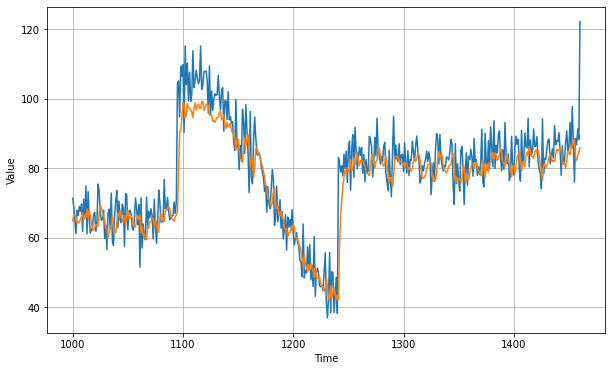

In [91]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()